In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !unzip "/content/drive/MyDrive/DL Project/Game of deep learning.zip" -d "/content/drive/MyDrive/DL Project"

In [3]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/content/drive/MyDrive/DL Project/Game of deep learning/train/images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2851972.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2877113.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2876169.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2870115.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2856050.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2866133.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2847733.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2872151.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2860068.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2869704.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/train/images/2868764.jpg
/content/drive/MyDrive/DL Project/Game of deep learning/tr

# Importing Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.math import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Data Import

In [5]:
train = pd.read_csv('/content/drive/MyDrive/DL Project/Game of deep learning/train/train.csv')

# Data Analysis

In [6]:
train.head()

image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2

In [7]:
train.tail()

image  category
6247  2881056.jpg         3
6248  1145083.jpg         2
6249  2898652.jpg         5
6250  2868175.jpg         3
6251  2784171.jpg         1

In [8]:
train.describe()

category
count  6252.000000
mean      2.657550
std       1.528998
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       5.000000

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     6252 non-null   object
 1   category  6252 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 97.8+ KB


In [10]:
train.shape

(6252, 2)

In [11]:
train.isnull().sum()

image       0
category    0
dtype: int64

<Axes: xlabel='category', ylabel='count'>

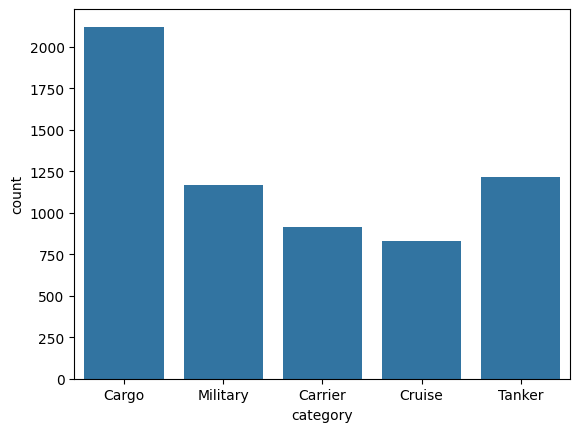

In [12]:
ship_categories = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}
sns.countplot(x=train["category"].map(ship_categories))

<Axes: ylabel='count'>

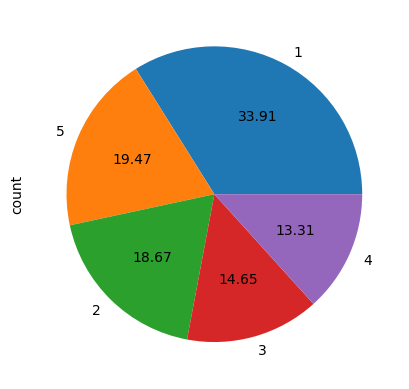

In [13]:
pie = train.loc[:, "category"].value_counts()
pie.plot.pie(autopct='%.2f')

<Axes: ylabel='count'>

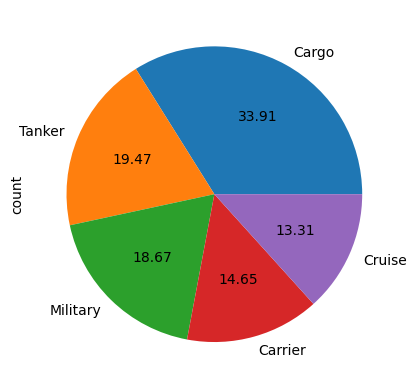

In [14]:
pie = train["category"].map(ship_categories).value_counts()
pie.plot.pie(autopct='%.2f')

# Data Preprocessing

**Function to load and preprocess an image**

In [15]:
path = '/content/drive/MyDrive/DL Project/Game of deep learning/train/images'
target_shape = (128, 128, 3)

def load_and_preprocess_image(image_path, target_shape):
    img = plt.imread(image_path)
    img = cv2.resize(img, (target_shape[1], target_shape[0]))  # Resize the image
    return img

**Load and preprocess images to an array of RGB colors**

In [16]:
refactor_size = 128
resized_image_list = []
all_paths = []

for i in range(len(train)):
    image_path = os.path.join(path, train["image"][i])
    img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)
    resized_image_list.append(imgarr)
    all_paths.append(image_path)

resized_image_list = np.asarray(resized_image_list) #List of preprocessed images

**Plotting first 20 Images**

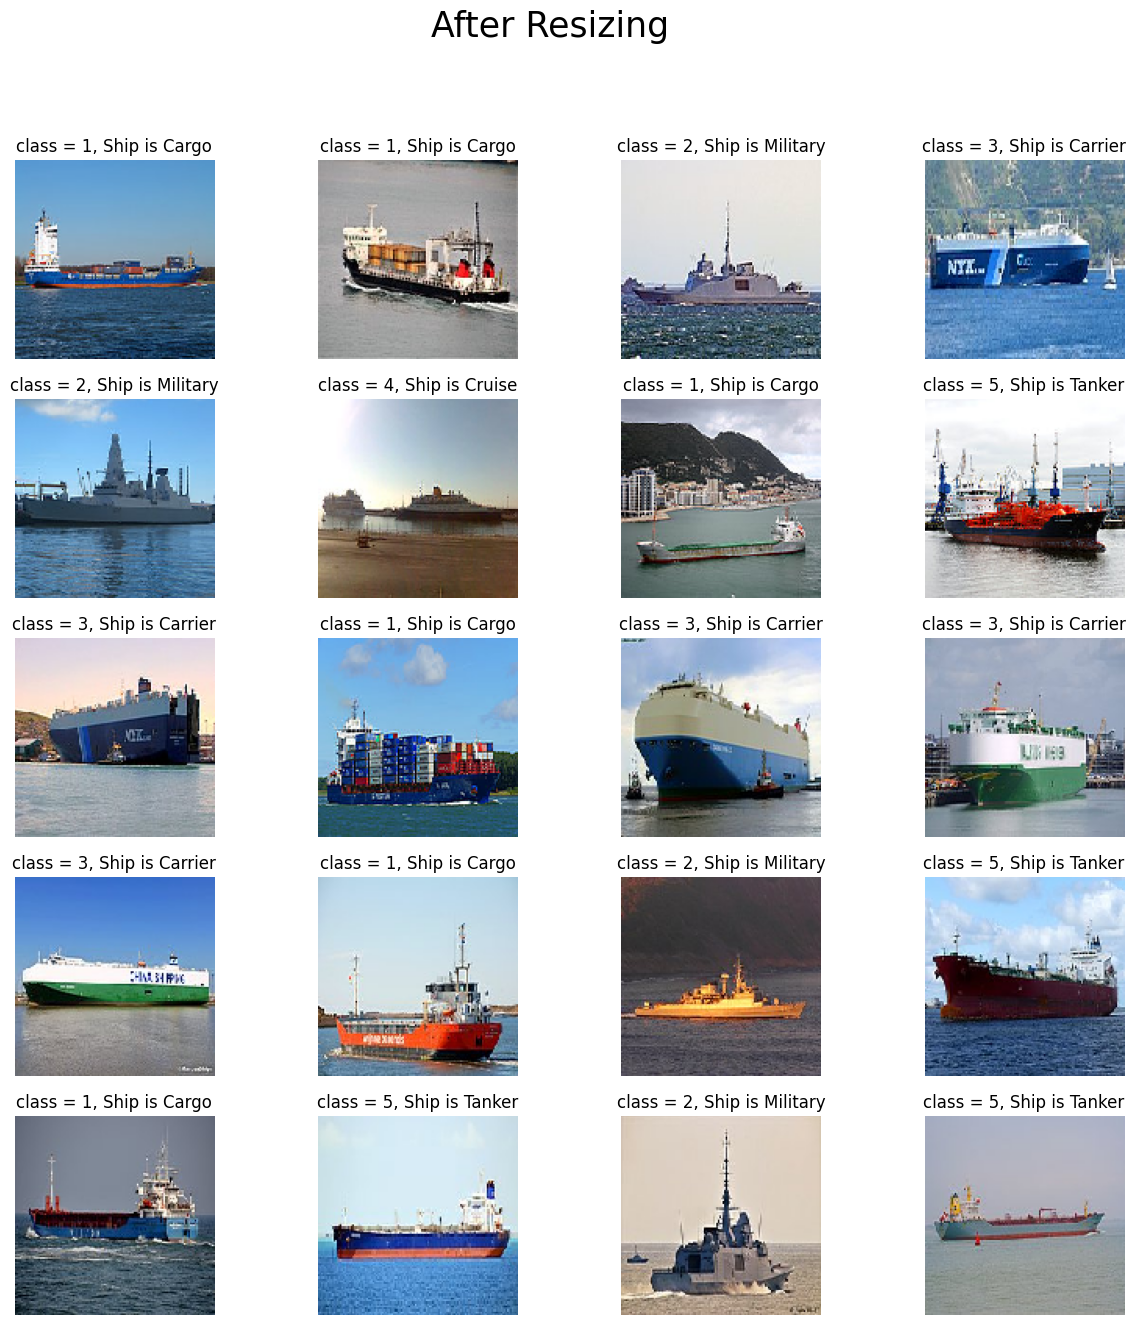

In [17]:
nrow = 5
ncol = 4
fig1 = plt.figure(figsize=(15, 15))
fig1.suptitle('After Resizing', size=25)
for i in range(20):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(resized_image_list[i])
    plt.title('class = {x}, Ship is {y}'.format(x=train["category"][i], y=ship_categories[train["category"][i]]))
    plt.axis('Off')
    plt.grid(False)
plt.show()

In [18]:
# Saving the preprocessed images in the desired folder

# from PIL import Image
# import csv

# output_dir = r'Game of deep learning\DL\train\Preprocessed'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for i, img_arr in enumerate(resized_image_list):
#     img_pil = Image.fromarray(np.uint8(img_arr*255))
#     img_path = os.path.join(output_dir, f'resized_image_list_{i}.jpg')
#     img_pil.save(img_path)
#     print(f'Saved images {i} to {img_path}')

In [19]:
# !pip install opencv-python

#### Data augmentation

In [20]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'), tf.keras.layers.RandomRotation(0.2),])
augmented_images = data_augmentation(resized_image_list)

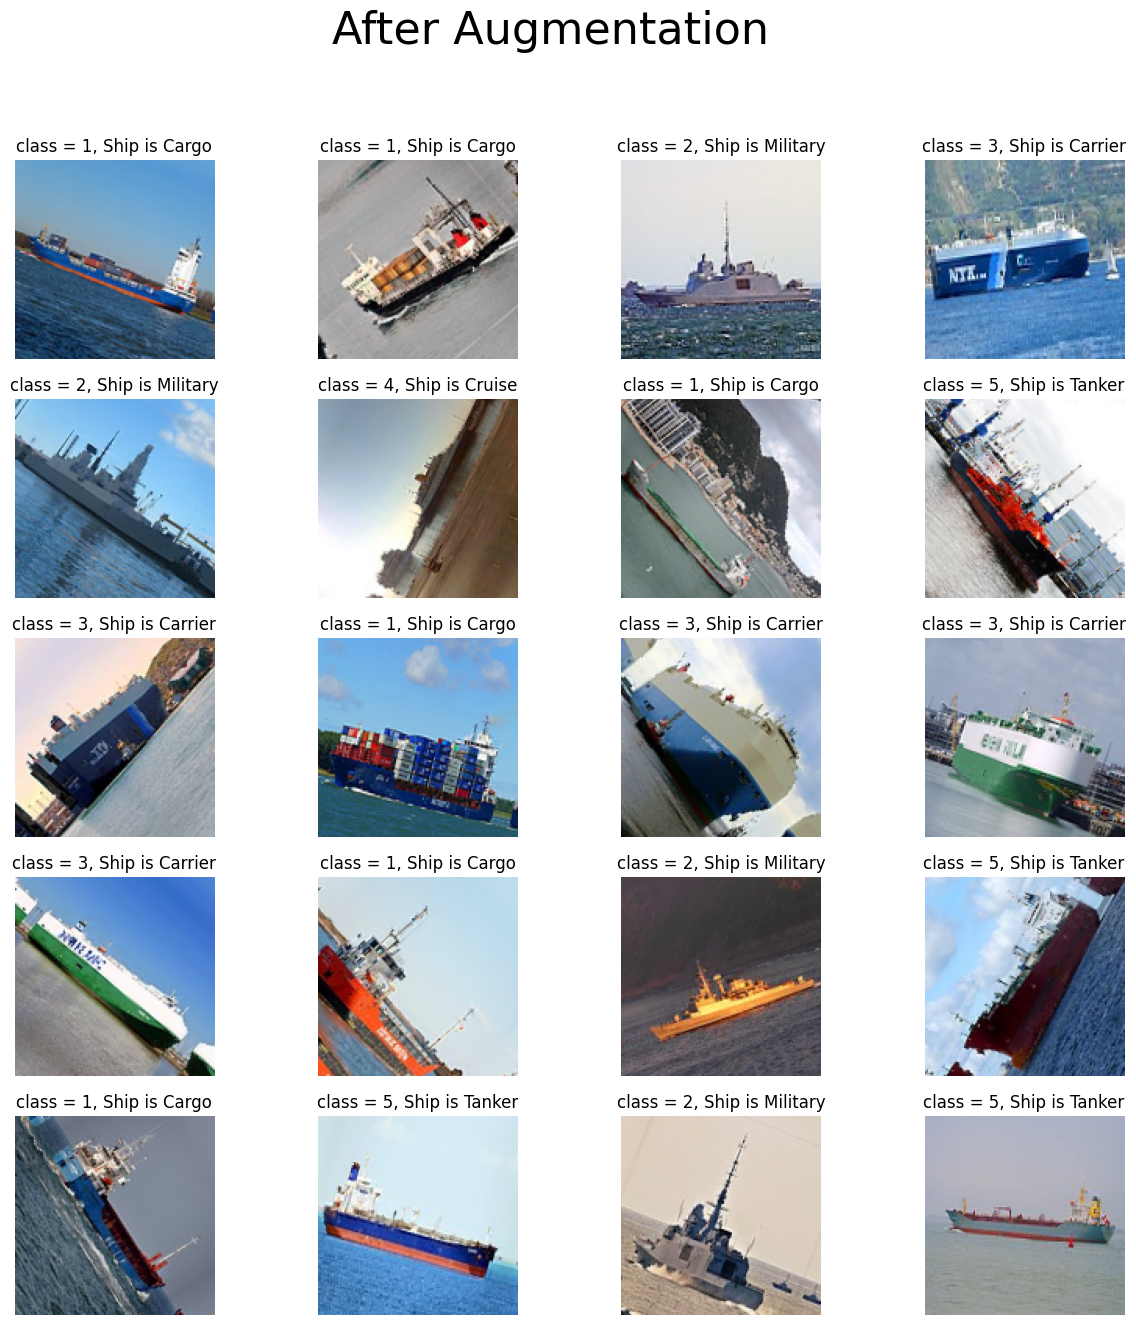

In [21]:
fig2 = plt.figure(figsize=(15, 15))
fig2.suptitle('After Augmentation', size=32)
for i in range(20):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(augmented_images[i])
    plt.title('class = {x}, Ship is {y}'.format(x=train["category"][i], y=ship_categories[train["category"][i]]))
    plt.axis('Off')
    plt.grid(False)
plt.show()

In [22]:
cat_values = train["category"] - 1
cat_values.value_counts()

category
0    2120
4    1217
1    1167
2     916
3     832
Name: count, dtype: int64

In [23]:
ship_categories = {0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tanker'}

### Train Test Split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(resized_image_list, cat_values, random_state=30)
print(x_train.shape, y_train.shape)

(4689, 128, 128, 3) (4689,)


### **CNN Model**

In [25]:
model = models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(5, activation='softmax')
])

In [26]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

#### Compile the model

In [27]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, callbacks=[checkpoint])

Epoch 1/50
147/147 [==============================] - ETA: 0s - loss: 1.4261 - accuracy: 0.3926
Epoch 1: val_accuracy improved from -inf to 0.43570, saving model to best_model.h5
147/147 [==============================] - 8s 33ms/step - loss: 1.4261 - accuracy: 0.3926 - val_loss: 1.3066 - val_accuracy: 0.4357
Epoch 2/50
144/147 [============================>.] - ETA: 0s - loss: 1.2444 - accuracy: 0.4770
Epoch 2: val_accuracy improved from 0.43570 to 0.49264, saving model to best_model.h5
147/147 [==============================] - 3s 22ms/step - loss: 1.2456 - accuracy: 0.4769 - val_loss: 1.1886 - val_accuracy: 0.4926
Epoch 3/50
145/147 [============================>.] - ETA: 0s - loss: 1.1510 - accuracy: 0.5269
Epoch 3: val_accuracy improved from 0.49264 to 0.52015, saving model to best_model.h5
147/147 [==============================] - 3s 21ms/step - loss: 1.1520 - accuracy: 0.5266 - val_loss: 1.1183 - val_accuracy: 0.5202
Epoch 4/50
145/147 [============================>.] - ETA: 0s

#### Load the best model saved during training

In [29]:
best_model = models.load_model('best_model.h5')

In [30]:
test_loss, best_test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print("\nBest Test Accuracy:", best_test_acc)

49/49 - 1s - loss: 0.6100 - accuracy: 0.7895 - 550ms/epoch - 11ms/step

Best Test Accuracy: 0.7895073294639587


#### Predictions using the best accuracy

In [31]:
best_predictions = best_model.predict(x_test)
best_predicted_classes = np.argmax(best_predictions, axis=1)

49/49 [==============================] - 1s 8ms/step


### Confusion matrix

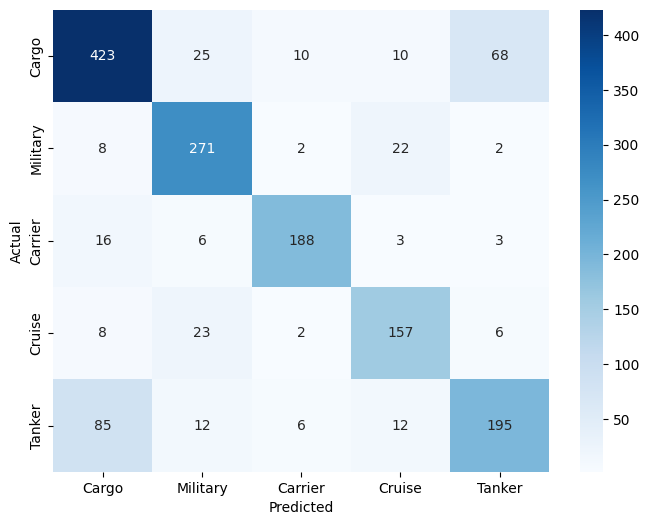

In [32]:
best_cm = confusion_matrix(y_test, best_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', xticklabels=ship_categories.values(), yticklabels=ship_categories.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Plotting first 20 predictions

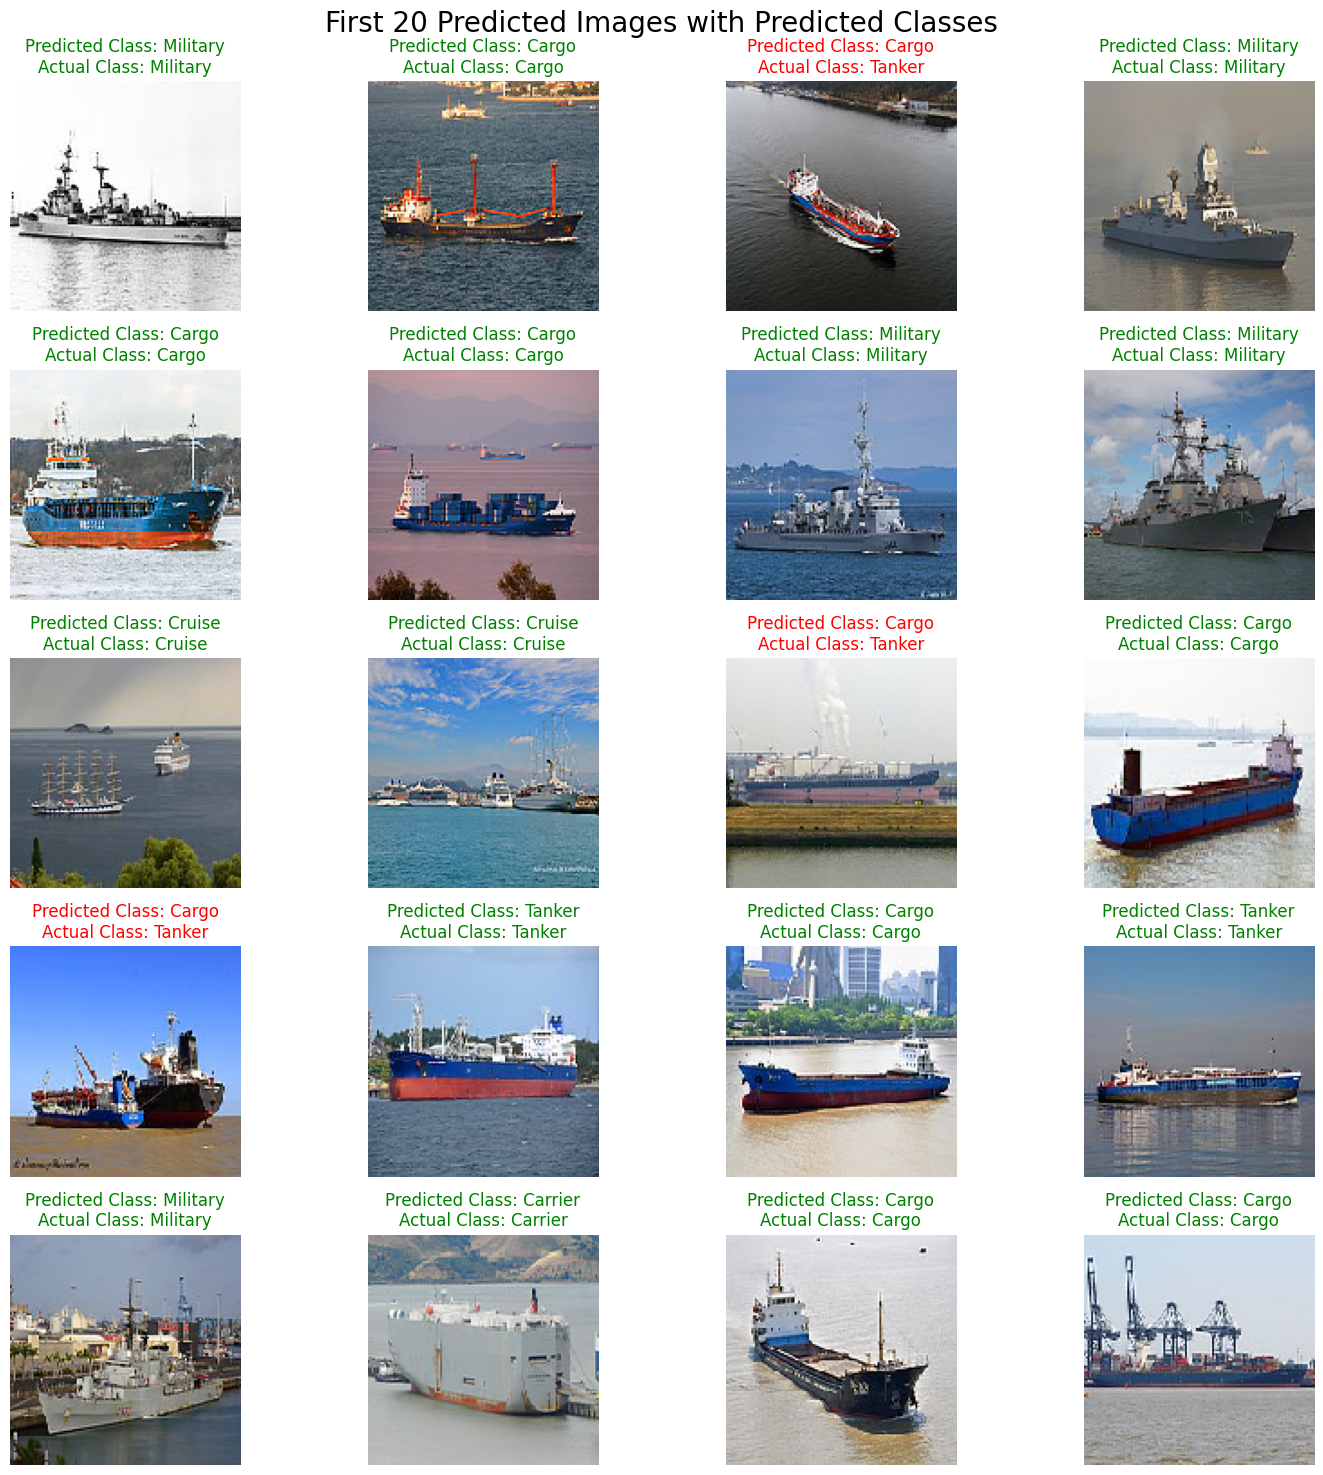

In [33]:
y_test = y_test.reset_index(drop=True)
plt.figure(figsize=(15, 15))
plt.suptitle('First 20 Predicted Images with Predicted Classes', size=20)
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(x_test[i])
    predicted_class_label = ship_categories[best_predicted_classes[i]]
    actual_class_label = ship_categories[y_test[i]]

    if best_predicted_classes[i] == y_test[i]:
        title_color = 'green'
    else:
        title_color = 'red'

    title = f'Predicted Class: {predicted_class_label}\nActual Class: {actual_class_label}'
    plt.title(title, color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

### **ResNet50 Model**

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from PIL import Image
from tqdm import tqdm

In [35]:
image_path = "/content/drive/MyDrive/DL Project/Game of deep learning/train/images/"
shape = (64, 64, 1)
batch_size1 = 24

In [36]:
train_images = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img(image_path + train['image'][i], target_size=shape, grayscale=True)
    img = image.img_to_array(img)
    img = img.astype(np.float32) / 255.0
    train_images.append(img)
X = np.array(train_images)

100%|██████████| 6252/6252 [00:20<00:00, 304.08it/s]


In [37]:
y_val1 = train['category'].subtract(1).values
y = to_categorical(y_val1, num_classes=len(ship_categories))

Validating the images

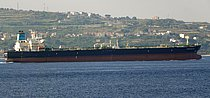

In [38]:
Image.open(image_path + train['image'][3254])

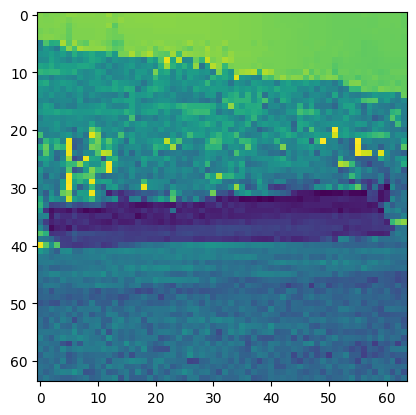

In [39]:
plt.imshow(X[3254])
plt.show()

In [40]:
resnet_model = ResNet50(include_top=False, weights=None, input_shape=shape)
layer = resnet_model.output
layer = Flatten()(layer)
layer = Dense(512, activation='tanh')(layer)
# layer = Dropout(0.3)(layer)
layer = Dense(128, activation='tanh')(layer)
# layer = Dropout(0.3)(layer)
layer = Dense(len(ship_categories), activation='softmax')(layer)
model1 = Model(inputs = resnet_model.input, outputs = layer)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 1)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [41]:
for layer in resnet_model.layers:
    layer.trainable = False

In [42]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4689, 64, 64, 1), (1563, 64, 64, 1), (4689, 5), (1563, 5))

In [44]:
aug_img = dict(featurewise_center=True, featurewise_std_normalization=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
datagen = image.ImageDataGenerator(**aug_img)

In [45]:
train_dataset1 = datagen.flow(X_train, y_train, batch_size=batch_size1)
test_dataset1 = datagen.flow(X_test, y_test, batch_size=batch_size1)

In [46]:
step_size_train = train_dataset1.n//train_dataset1.batch_size
step_size_val = test_dataset1.n//test_dataset1.batch_size

In [47]:
history1 = model1.fit(train_dataset1, steps_per_epoch=step_size_train, epochs=50, validation_data=test_dataset1, validation_steps=step_size_val)

Epoch 1/50
195/195 [==============================] - 13s 41ms/step - loss: 0.4955 - accuracy: 0.3348 - val_loss: 0.4863 - val_accuracy: 0.3327
Epoch 2/50
195/195 [==============================] - 5s 26ms/step - loss: 0.4835 - accuracy: 0.3428 - val_loss: 0.4804 - val_accuracy: 0.3378
Epoch 3/50
195/195 [==============================] - 6s 29ms/step - loss: 0.4822 - accuracy: 0.3417 - val_loss: 0.4836 - val_accuracy: 0.3346
Epoch 4/50
195/195 [==============================] - 5s 27ms/step - loss: 0.4839 - accuracy: 0.3430 - val_loss: 0.4846 - val_accuracy: 0.3288
Epoch 5/50
195/195 [==============================] - 7s 34ms/step - loss: 0.4829 - accuracy: 0.3398 - val_loss: 0.4836 - val_accuracy: 0.3404
Epoch 6/50
195/195 [==============================] - 7s 33ms/step - loss: 0.4840 - accuracy: 0.3387 - val_loss: 0.4836 - val_accuracy: 0.3385
Epoch 7/50
195/195 [==============================] - 5s 27ms/step - loss: 0.4825 - accuracy: 0.3413 - val_loss: 0.4831 - val_accuracy: 0.334

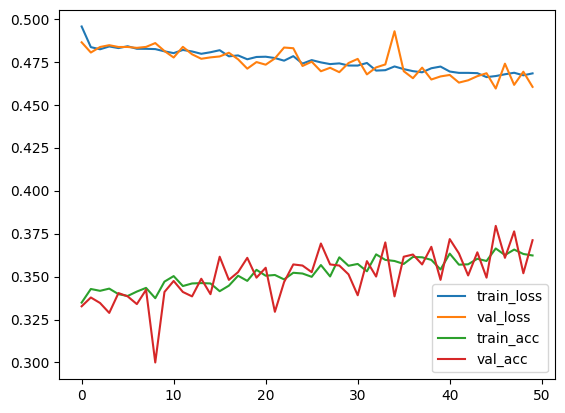

In [52]:
plt.plot(history1.history["loss"], label="train_loss")
plt.plot(history1.history["val_loss"], label="val_loss")
plt.plot(history1.history["accuracy"], label="train_acc")
plt.plot(history1.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

### **Xception Model**

In [53]:
path = '/content/drive/MyDrive/DL Project/Game of deep learning/train/images'

img_list = list(train['image'])

data_img = []

for each in img_list:
    each_path = os.path.join(path, each)
    each_img = cv2.imread(each_path)
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    each_img_resized = cv2.resize(each_img, (128,128))
    data_img.append(each_img_resized)

X2 = np.array(data_img)
print('Shape of X: ', X.shape)

Shape of X:  (6252, 64, 64, 1)


In [54]:
from sklearn.preprocessing import OneHotEncoder

y2 = OneHotEncoder(dtype='int8', sparse=False).fit_transform(train['category'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (6252, 5)


In [55]:
X_data2, X_test2, y_data2, y_test2 = train_test_split(X2, y2, test_size=0.15, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_data2, y_data2, test_size=0.2, random_state=42)

print('X_train shape: ', X_train2.shape)
print('y_train shape: ', y_train2.shape)
print('X_val shape  : ', X_val2.shape)
print('y_val shape  : ', y_val2.shape)
print('X_test shape : ', X_test2.shape)
print('y_test shape : ', y_test2.shape)

X_train shape:  (4251, 128, 128, 3)
y_train shape:  (4251, 5)
X_val shape  :  (1063, 128, 128, 3)
y_val shape  :  (1063, 5)
X_test shape :  (938, 128, 128, 3)
y_test shape :  (938, 5)


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

validation_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

train_gen.fit(X_train2)
validation_gen.fit(X_val2)

In [57]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

batch_size = 100
epochs = 15

base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)

head = Dense(5, activation='softmax')(x)
model2 = Model(inputs=base.input, outputs=head)

model2.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit_generator(train_gen.flow(X_train2, y_train2, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val2, y_val2, batch_size=batch_size),
                              steps_per_epoch = X_train2.shape[0] // batch_size)

Epoch 1/15
42/42 [==============================] - 70s 917ms/step - loss: 0.9288 - accuracy: 0.6367 - val_loss: 5.0408 - val_accuracy: 0.4214
Epoch 2/15
42/42 [==============================] - 31s 725ms/step - loss: 0.6102 - accuracy: 0.7634 - val_loss: 1.3819 - val_accuracy: 0.6717
Epoch 3/15
42/42 [==============================] - 31s 735ms/step - loss: 0.5281 - accuracy: 0.8034 - val_loss: 1.3851 - val_accuracy: 0.7008
Epoch 4/15
42/42 [==============================] - 33s 783ms/step - loss: 0.4651 - accuracy: 0.8239 - val_loss: 0.9794 - val_accuracy: 0.7385
Epoch 5/15
42/42 [==============================] - 30s 717ms/step - loss: 0.4392 - accuracy: 0.8371 - val_loss: 0.9588 - val_accuracy: 0.6999
Epoch 6/15
42/42 [==============================] - 33s 779ms/step - loss: 0.4037 - accuracy: 0.8464 - val_loss: 0.6303 - val_accuracy: 0.7968
Epoch 7/15
42/42 [==============================] - 34s 802ms/step - loss: 0.3866 - accuracy: 0.8524 - val_loss: 0.5204 - val_accuracy: 0.8288

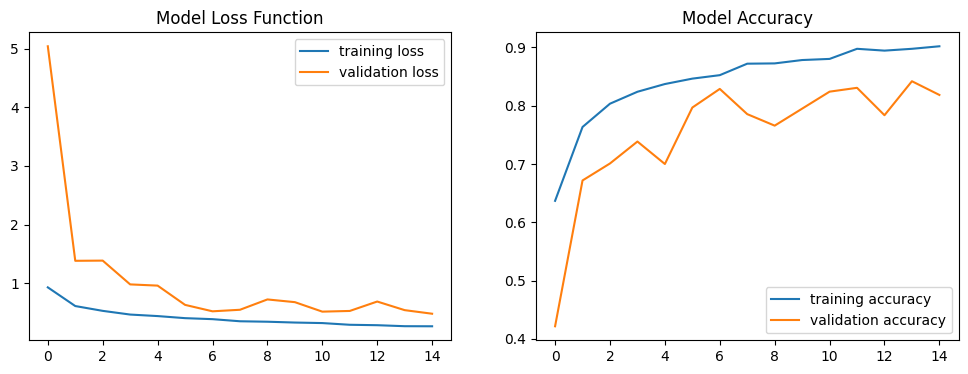

In [59]:
history_df = pd.DataFrame(history2.history)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend()

30/30 [==============================] - 1s 43ms/step


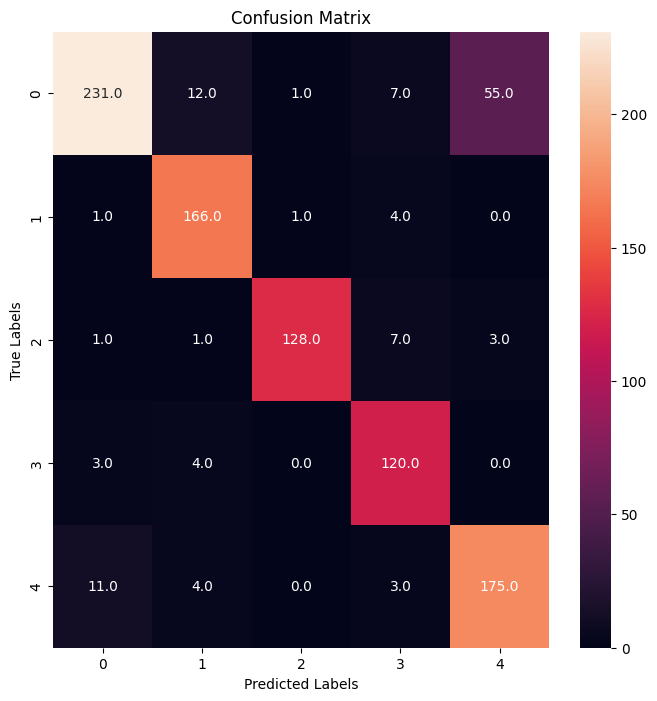

In [61]:
y_pred2 = model2.predict(X_test2)

y_pred_classes = np.argmax(y_pred2, axis = 1)

y_test_classes = np.argmax(y_test2, axis = 1)

confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84       306
           1       0.89      0.97      0.92       172
           2       0.98      0.91      0.95       140
           3       0.85      0.94      0.90       127
           4       0.75      0.91      0.82       193

    accuracy                           0.87       938
   macro avg       0.88      0.90      0.89       938
weighted avg       0.88      0.87      0.87       938



In [63]:
test_img = pd.read_csv('/content/drive/MyDrive/DL Project/Game of deep learning/test_ApKoW4T.csv')
sample_img = test_img.sample(5)

img_list = list(sample_img['image'])

sample_img_data = []

for each in img_list:
    each_path = os.path.join(path, each)
    each_img = cv2.imread(each_path)
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    each_img_resized = cv2.resize(each_img, (128,128))
    sample_img_data.append(each_img_resized)

sample_img_data = np.array(sample_img_data)
print('Shape of X: ', sample_img_data.shape)

Shape of X:  (5, 128, 128, 3)


1/1 [==============================] - 0s 259ms/step


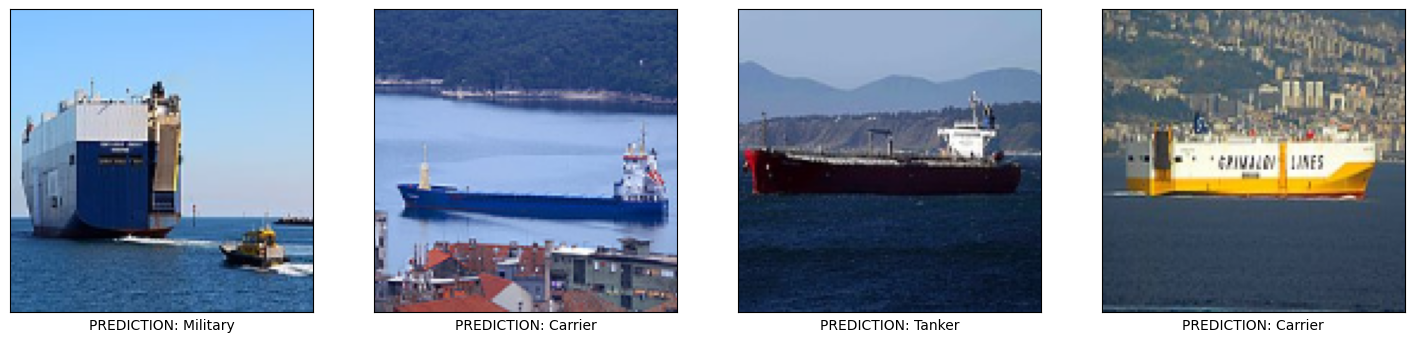

In [64]:
sample_pred = model.predict(sample_img_data)
sample_classes = np.argmax(sample_pred, axis = 1)

i = 0
plt.figure(figsize=(18,9))
for each in range(4):
    i += 1
    plt.subplot(2,4,i)
    plt.imshow(sample_img_data[each])
    plt.xlabel('PREDICTION: ' + str(ship_categories[sample_classes[each]]))
    plt.xticks([])
    plt.yticks([])